<a href="https://colab.research.google.com/github/PaulCreaserML/PaulCreaserML.github.io/blob/master/meter_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import os
import random
import pandas as pd
import numpy as np

import skimage.io as skio
import skimage.transform as sktrans
from skimage.color import rgb2gray

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # Sampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as nnf

# Functional transforms
import torchvision.transforms.functional as TF
# Transforms
from torchvision import transforms
# Pretrained Models
from torchvision import models
# Summary
from torchsummary import summary

# Colab Check

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


# GDrive

In [4]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#CSV File, Directory settings etc...

In [5]:
# 80x45
csv_file         = "gdrive/MyDrive/meter_data/meter_all.csv"
all_csv_file     = "gdrive/MyDrive/meter_data/meter_all.csv"

model_output_dir = "gdrive/MyDrive/meter_data/models/"

meter_images  = "gdrive/MyDrive/meter_data/image_data/meter.zip"

# All
local_input_file_dir = "meter/"

# File Check

In [6]:

print( csv_file )

!ls -al $csv_file
!wc -l  $csv_file

gdrive/MyDrive/meter_data/meter_all.csv
-rw------- 1 root root 12634 Jan 30 01:49 gdrive/MyDrive/meter_data/meter_all.csv
432 gdrive/MyDrive/meter_data/meter_all.csv


# Transfer Learning for Image to Image

*   Use MobileNetV2 for base
*   Replace classification layer with convolution layers

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# BASIC METER FCNN V1

In [8]:
# Clock CNN
class MeterFCNNV1(nn.Module):
    def __init__(self, mobilenet_version=None):
        super(MeterFCNNV1, self).__init__()

        self.mobilenet_version = mobilenet_version

        self.model_mobilenet = None
        if mobilenet_version is None:
          self.model_mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
          for param in self.model_mobilenet.parameters():
            param.requires_grad = False
        elif mobilenet_version=="V3_SMALL":
          self.model_mobilenet = models.mobilenet_v3_small(pretrained=True)
          for param in self.model_mobilenet.parameters():
            param.requires_grad = False
        elif mobilenet_version=="V3_LARGE":
          self.model_mobilenet = models.mobilenet_v3_large(pretrained=True)
          for param in self.model_mobilenet.parameters():
            param.requires_grad = False          
          
        if mobilenet_version is None:
          self.model_mobilenet.features[ 7] = Identity()
          self.model_mobilenet.features[ 6] = Identity()
          self.model_mobilenet.features[ 8] = Identity()
          self.model_mobilenet.features[ 9] = Identity()
          self.model_mobilenet.features[10] = Identity()
          self.model_mobilenet.features[11] = Identity()
          self.model_mobilenet.features[12] = Identity()
          self.model_mobilenet.features[13] = Identity()
          self.model_mobilenet.features[14] = Identity()
          self.model_mobilenet.features[15] = Identity()
          self.model_mobilenet.features[15] = Identity()
          self.model_mobilenet.features[16] = Identity()
          self.model_mobilenet.features[17] = Identity()
          self.model_mobilenet.features[18] = Identity()

          self.m_conv = nn.Sequential(
            nn.Conv2d(32,  32, kernel_size=3), # 32->48
            nn.ReLU6(inplace=True),
            nn.Conv2d(32,  32, kernel_size=3), # 32->48
            nn.ReLU6(inplace=True),
            nn.Conv2d(32,  4, kernel_size=3),   # 1->2
            nn.ReLU6(inplace=True)
            )

          self.m_1 = nn.Linear( 240, 24 ) # 400, 24 )
          self.m_2 = nn.Linear(  24, 21 )
       
        elif mobilenet_version=="V3_SMALL":
          pass # TODO
        elif mobilenet_version=="V3_LARGE":
          pass # TODO


    def my_name(self):
      if self.mobilenet_version is not None:
        return "Basic_Meter_FCNN_V1" + self.mobilenet_version
      else:
        return "Basic_Meter_FCNN_V1"

    def forward(self, x):
      x = self.model_mobilenet.features(x)
      #print("Features ", x.shape)

      x_m  = self.m_conv(x)
      x_m = torch.flatten(x_m, start_dim=1)
      #print("Flat ", x_m.shape)
      x_m  = self.m_1(x_m)
      x_m = torch.sigmoid( x_m )
      x_m  = self.m_2(x_m)

      x_m = torch.sigmoid( x_m ) # F.log_softmax(x_hr, dim=1)

      return x_m

# Initialize Model

In [9]:
def initialize_model( model_type, mobilenet_version):
  meter_model = None 
  if model_type is not None:
    if model_type == "FCNN":
      meter_model = MeterFCNNV1(mobilenet_version=mobilenet_version) # "V3_LARGE") # V3_SMALL V3_LARGE, None

  print("Model name", meter_model.my_name())

  return meter_model

# Train Mask Only

In [10]:
def train_meter_model( meter_model, optimizer, device, train_loader, test_dataloader, epoch, path, meter_loss_fn, log_interval = 40):
 
    meter_model.train()

    epoch_loss = 0  #test_loss + loss.item()

    # for data, target in train_loader:
    for batch_idx, data in enumerate(train_loader):

      input_data  = data[0].to(device) #, non_blocking=True) # Speed Up
      input_data  = input_data.repeat(1, 3, 1, 1) # Grayscale to RGB

      meter_target = data[2].to(device) #,, non_blocking=True) # Speed Up

      #print(" hr_target ", hr_target.shape)
      #print(" mn_target ", mn_target.shape)

      meter_output = meter_model(input_data)

      #print(" hr_output ", hr_output.shape)
      #print(" mn_output ", mn_output.shape)

      t_loss = meter_loss_fn(meter_output, meter_target )

      t_loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      epoch_loss = epoch_loss + t_loss.item()

      if batch_idx % log_interval == 0:
        loss_sum  = t_loss.mean()
        print('\nTrain Epoch: {} [{} {}/{} ({:.0f}%)]\tTotal Loss: {:.6f}'.format(
            epoch, batch_idx, batch_idx * data[0].shape[0], len(train_loader.dataset),
           100. * batch_idx / len(train_loader), loss_sum.item() ))
                
        
    meter_model.eval()
    index= 0
    for batch_idx, data in enumerate(train_loader):

      input_data  = data[0].to(device) #, non_blocking=True) # Speed Up
      input_data  = input_data.repeat(1, 3, 1, 1) # Grayscale to RGB

      meter_target = data[1].to(device) #,, non_blocking=True) # Speed Up

      meter = data[1] #,, non_blocking=True) # Speed Up

      meter_output = meter_model(input_data)

      index = index + 1

      if index > 4:
        break

      #print(" hr_output ", hr_output.shape)
      #print(" mn_output ", mn_output.shape)


      device_cpu = torch.device( "cpu")
      meter_prob = F.softmax(meter_output, dim=1).to(device_cpu).detach()

      meter_est = torch.argmax(meter_prob, dim=1)

      print("Actual ", meter, " Est. ", meter_est )

    #max_mask_error, total_mask_error, max_count_error, total_count_error, file_name, result_list = assess_performance(  mask_model, test_dataloader, thresholds=[  0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85 ], verbose= False )
    #print("\nEpech ", epoch, "Epoch Loss ", epoch_loss )    
    #print("\nEval Max Error ", max_mask_error, ", Total error  ", total_mask_error, ", File ", file_name )    
    save_model_checkpt( meter_model, optimizer, epoch, path, epoch_loss )


# Train Mask and Count AI Model

# Copy To Local Drive

In [11]:
!ls -l $meter_images

-rw------- 1 root root 2491433 Jan 30 01:49 gdrive/MyDrive/meter_data/image_data/meter.zip


# Copy Training Data

In [47]:
!cp $meter_images . 

In [46]:
!rm -rf meter/

In [ ]:
!unzip meter.zip

In [49]:
!ls -l meter | wc -l

433


# Current Dataloader

In [130]:
class CustomDataset_From_Disk(Dataset):
  def __init__(self, csv_file, transform=None):

    self.transform = transform
    self.train = pd.read_csv(csv_file)
    self.x_train = self.train.iloc[:,0].values
    self.y_train_1 = self.train.iloc[:,1].values

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self, idx):
    img_file = self.x_train[idx]
    img_data_orig = skio.imread(img_file)

    if img_data_orig.ndim>=3:
        img_data = rgb2gray(img_data_orig)
    else:
        img_data = img_data_orig/255.0


    y_train_1 = self.y_train_1[idx]%21

    #print(y_train_1 )

    y_hot_1 = torch.FloatTensor(21)

    y_hot_1.zero_()
    
    y_hot_1[y_train_1] = 1

    img_data = self.transform(img_data).float()
    # Invert
    if random.random() > 0.5:
      img_data = TF.invert(img_data)

    # Contrast
    img_data = TF.adjust_contrast(img_data, 1.1 - ( random.random()/5.0 ))

    # Patch Left and Right
    if random.random() > 0.5:
      if y_train_1 < 10: # Left Half
        img_data[:, :, 70:] =random.random()
      else: # Right half
        img_data[:, :, 0:58] =random.random()

    # Patch Below Needle
    if random.random() > 0.5:
      img_data[:, 53:83, :] =random.random()

    img_data = img_data.unsqueeze(0)
    #print(img_data.shape)
    #print( y_train_1)
    
    #print( y_hot_1)

    #print(img_data.shape)

    rand_interp = random.random()  
    if rand_interp < 0.2:
      img_data = nnf.interpolate(img_data, size=(96, 128), mode='nearest')
    #elif rand_interp < 0.7:
    #  img_data = nnf.interpolate(img_data, size=(96, 128), mode='linear')
    else:
      img_data = nnf.interpolate(img_data, size=(96, 128), mode='bilinear') 
    img_data = img_data[0]
    #print(img_data.shape)

    img_data_orig = self.transform(img_data_orig/255).float() 

    return img_data, y_train_1, y_hot_1, img_data_orig

# Transforms to augment data
transform = transforms.Compose([
        transforms.ToTensor(),
        ])

# Init

In [131]:
train_set = CustomDataset_From_Disk(csv_file, transform)
train_dataloader = DataLoader(train_set, batch_size=8, shuffle=True, pin_memory=True, num_workers=0) #True), # 10 -> 16

In [132]:
print("1:-", train_dataloader )

train_dataloader_iter = iter(train_dataloader)


1:- <torch.utils.data.dataloader.DataLoader object at 0x7f235f4acdf0>


In [19]:
#while True:
train_features = next(train_dataloader_iter)

# Check Point Save

In [20]:
def save_model_checkpt( model, optimizer, epoch, path, loss ):
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      }, path)

**Check Point Load**

In [21]:
def load_model_checkpt( model, path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  optimizer = None
  return model, epoch, path, loss

# Train Model Mask

In [22]:
def train_meter_model_wrapper( meter_model, model_path, restart_epoch=None):
  print("1:-", train_dataloader )

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  meter_loss_fn = nn.CrossEntropyLoss() #  nn.BCELoss() # nn.CrossEntropyLoss() 

  # Set optimizers
  print("Optimizer Set Up")
  optimizer    = optim.Adam(meter_model.parameters(), lr=0.00004)  #, lr=0.00002)

  print("Schedule Set Up")
  scheduler1 = StepLR(optimizer,     step_size=1, gamma=0.99)

  meter_model.to(device)

  test_dataloader = None
  for epoch in range(1, 10000 + 1):

    if restart_epoch is not None:
      if epoch % restart_epoch == 0:
        print("Schedule Reset")
        scheduler1 = StepLR(optimizer,     step_size=1, gamma=0.99)

    train_meter_model(meter_model, optimizer, device,  train_dataloader, test_dataloader, epoch, model_path, meter_loss_fn, log_interval=400)

    scheduler1.step()

# Train

In [ ]:
from datetime import datetime
now = datetime.now() # current date and time

#meter_model = initialize_model("FCNN", None)

date_time = now.strftime("%m_%d_%Y_%H_%M_%S")
path = model_output_dir +  meter_model.my_name() + date_time + "meter_transfer_chkpt.pt"

train_meter_model_wrapper( meter_model, path, 100)

ストリーミング出力は最後の 5000 行に切り捨てられました。
Actual  tensor([18, 16, 13, 10, 10, 17, 18,  3])  Est.  tensor([18, 16, 13, 10, 10, 17, 18,  3])
Actual  tensor([12,  3,  5, 17, 17,  1,  6, 18])  Est.  tensor([12,  3,  5, 17, 17,  1,  6, 18])
Actual  tensor([ 9,  6, 19,  7, 14,  9, 14,  2])  Est.  tensor([ 9,  6, 19,  7, 14,  9, 14,  2])
Actual  tensor([ 7,  0,  2,  1, 14, 10, 12,  3])  Est.  tensor([ 7,  0,  2,  1, 14, 10, 12,  3])

Train Epoch: 912 [0 0/431 (0%)]	Total Loss: 2.396645
Actual  tensor([ 0, 15, 14,  5, 19,  1, 15, 19])  Est.  tensor([ 0, 15, 14,  5, 19,  1, 15, 19])
Actual  tensor([16, 15,  1, 12, 14, 18, 18, 18])  Est.  tensor([16, 15,  1, 12, 14, 18, 18, 18])
Actual  tensor([ 3, 13, 14, 20,  5,  8,  1, 10])  Est.  tensor([ 3, 13, 14, 20,  5,  8,  1, 10])
Actual  tensor([ 9, 19, 13, 13,  7, 19, 19,  5])  Est.  tensor([ 9, 19, 13, 13,  7, 19, 19,  5])

Train Epoch: 913 [0 0/431 (0%)]	Total Loss: 2.366321
Actual  tensor([14,  9, 17,  9,  1, 12, 13, 12])  Est.  tensor([14,  9, 17,  9,  1, 

# Model Path

In [ ]:
print(path)

gdrive/MyDrive/meter_data/models/Basic_Meter_FCNN_V101_28_2023_11_20_36meter_transfer_chkpt.pt


**Continue Training Saved Model**

In [24]:
def load_model_checkpt( model, path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  return model, epoch, path, loss


# Load Pretrained Model

In [25]:
meter_model = initialize_model("FCNN", None)
path = "gdrive/MyDrive/meter_data/models/Basic_Meter_FCNN_V101_29_2023_09_25_52meter_transfer_chkpt.pt" # Basic_Meter_FCNN_V101_28_2023_11_50_03meter_transfer_chkpt.pt" # TODO"
meter_model, epoch, path, loss = load_model_checkpt( meter_model, path)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Model name Basic_Meter_FCNN_V1


# Check Model

In [154]:
class CustomTestDataset_From_Disk(Dataset):
  def __init__(self, csv_file, transform=None):

    self.transform = transform
    self.train = pd.read_csv(csv_file)
    self.x_train = self.train.iloc[:,0].values
    self.y_train_1 = self.train.iloc[:,1].values

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self, idx):
    img_file = self.x_train[idx]
    img_data_orig = skio.imread(img_file)

    if img_data_orig.ndim>=3:
        img_data = rgb2gray(img_data_orig)
    else:
        img_data = img_data_orig/255.0


    y_train_1 = self.y_train_1[idx]%21

    #print(y_train_1 )

    y_hot_1 = torch.FloatTensor(21)

    y_hot_1.zero_()
    
    y_hot_1[y_train_1] = 1

    img_data = self.transform(img_data).float()

    img_data = img_data.unsqueeze(0)
    #print(img_data.shape)
    #print( y_train_1)
    
    #print( y_hot_1)

    #print(img_data.shape)

    rand_interp = random.random()  
    if rand_interp < 0.5:
      img_data = nnf.interpolate(img_data, size=(96, 128), mode='nearest')
    #elif rand_interp < 0.7:
    #  img_data = nnf.interpolate(img_data, size=(96, 128), mode='linear')
    else:
      img_data = nnf.interpolate(img_data, size=(96, 128), mode='bilinear') 
    img_data = img_data[0]
    #print(img_data.shape)

    img_data_orig = self.transform(img_data_orig/255).float() 

    return img_data, y_train_1, y_hot_1, img_data_orig

# Transforms to augment data
transform = transforms.Compose([
        transforms.ToTensor(),
        ])

In [151]:

test_set = CustomTestDataset_From_Disk(csv_file, transform)
#test_set = CustomDataset_From_Disk(csv_file, transform)

test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True) #True), # 10 -> 16
test_dataloader_iter = iter(test_dataloader)

In [152]:
test_features = next(test_dataloader_iter)

In [153]:
import torch.nn.functional as nnf
import numpy as np
import matplotlib.pyplot as plt

In [142]:
def display_result( meter_model, input_image, value, input_image_orig ):

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  device_cpu = torch.device( "cpu")

  meter_model.eval()
  meter_model.to(device)

  with torch.no_grad():
    # Input
    input_image = input_image.to(device) 
    input_image  = input_image.repeat(1, 3, 1, 1)

    hr_output = meter_model(input_image)

    input_np     = input_image[0].to(device_cpu).permute(1, 2, 0).numpy()
    input_np_0   = input_np

    hr_prob = F.softmax(hr_output, dim=1).to(device_cpu).detach()

    hr_est = torch.argmax(hr_prob[0])

    hr = hr_est.item()


    fig, axs = plt.subplots(1, 1, figsize=(20,10))
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(wspace=0, hspace=0)

    print("9",flush=True)

    plt.text( 10, 10, "Estimate:-" +str(hr/2)+ " V", bbox=dict(fill=False, edgecolor='red', linewidth=2), color="white", fontsize=26)

    value = value.item()
    print("Estimated :- ", hr/2, " Actual :- ", value/2)
    plt.text(60, 10, "Actual:- "+ str(int(value)/2)+ " V", bbox=dict(fill=False, edgecolor='red', linewidth=2), color="white", fontsize=26)

    print("10",flush=True)

    # Target
    input_image_orig = input_image_orig.to(device_cpu)[0].permute(1, 2, 0).numpy() 
    axs.imshow(input_image_orig) # [0].permute(1, 2, 0).numpy() ) #_orig)
    #axs.imshow(input_image[0].permute(1, 2, 0).numpy() ) #_orig)
       
    return


In [155]:
#display_result( model, train_features[0], train_features[1],0 #)
test_features = next(test_dataloader_iter)

print( test_features[0].shape, test_features[1].shape, test_features[3].shape  )
input_image_orig = test_features[3].to("cpu")[0].permute(1, 2, 0).numpy()
print( test_features[0].shape, test_features[1].shape, input_image_orig.shape  )



torch.Size([1, 1, 96, 128]) torch.Size([1]) torch.Size([1, 3, 90, 126])
torch.Size([1, 1, 96, 128]) torch.Size([1]) (90, 126, 3)


9
Estimated :-  9.5  Actual :-  9.5
10


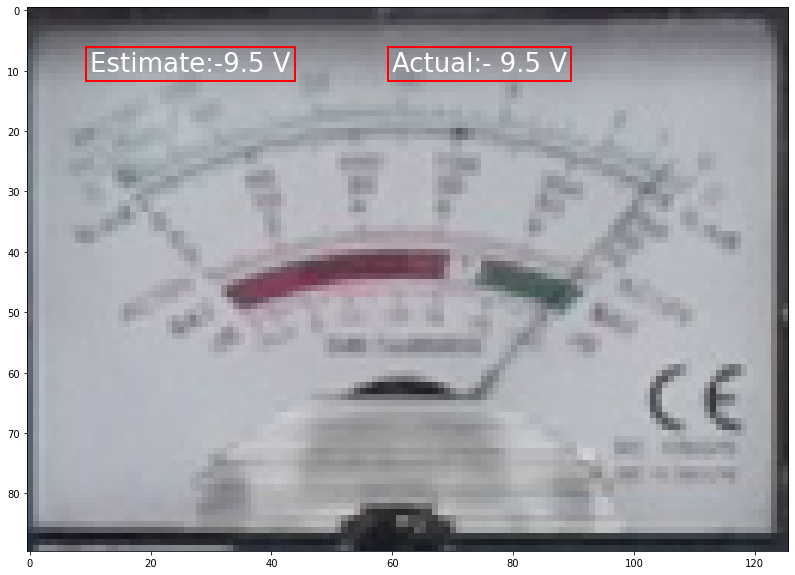

In [201]:
test_features = next(test_dataloader_iter)
#print( meter_model )
display_result( meter_model, test_features[0], test_features[1], test_features[3] )

# Save Image

In [ ]:
def save_result( mask_model, input, path = None, filename=None, threshold = 0.5 ):

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  mask_model.eval()
  mask_model.to(device)

  with torch.no_grad():
    # Input
    input        = input.repeat(1, 3, 1, 1) # Grayscale to RGB
    input_np     = input.numpy()
    input_np_0   = input_np[0]
    input_np_2d = input_np_0[0]*255
  
    model_output = mask_model(input.to(device))
    if len(model_output)== 2:
      output, counter_out = model_output[0], model_output[1]
    else:
      output, counter_out = model_output, None
  
    output[output < threshold] = 0
    output[output >= threshold] = 1
    output = clean4DMasks( output) 

    output_temp = output
    output_np = output_temp[0].cpu().detach().numpy() 
    output_np = output.cpu().detach().numpy()
    output_np = cleanMask( output_np[0][0]*255)

    output_file = path + filename 
    print("output", output_file )

    cv2.imwrite(output_file, output_np)





In [ ]:
class SaveDataset(Dataset):
  def __init__(self, csv_file, transform=None):

    self.transform=transform
    self.image_df = pd.read_csv(csv_file)

  def __len__(self):
    return self.image_df.shape[0]

  def __getitem__(self, idx):

      input_img_name  = self.image_df.iloc[idx, 0]
      input_img_data = skio.imread(input_img_name)

      if input_img_data.ndim==3:
        # Be careful here
        # If int 0->255
        # If floaｔ 0->1.0 
        # ( normalization going on here!!!)
        input_img_data = rgb2gray(input_img_data)
      else:
        input_img_data = input_img_data/255



      input_img_data = self.transform(input_img_data).float()

      return input_img_data, input_img_name

# Transforms to augment data
transform = transforms.Compose([
        transforms.ToTensor(),
        ])

In [ ]:
save_set = SaveDataset(csv_file, transform)
save_dataloader = DataLoader(save_set, batch_size=1, shuffle=False, pin_memory=True, num_workers=0) #True),

In [ ]:
#display_result( model, train_features[0], train_features[1],0 )
import cv2

file_dir= "output_images/car_counter"


file_path= "output_images/"
!mkdir -p $file_dir

!rm  $file_dir/*

for batch_idx, save_features in enumerate(save_dataloader):

  save_result( heatmap_model, save_features[0], path=file_path, filename=save_features[1][0], threshold=0.8)

#Para_FCNN_V112_01_2022_13_22_42car_mask_transfer_chkpt

In [ ]:
!zip -r  result.zip $file_path

In [ ]:
from google.colab import files
#files.download("result.zip")
files.download("video.avi")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import time
from os.path import isfile, join
import cv2

In [ ]:
pathIn= 'output_images/car_counter/'
pathOut = 'video.avi'
fps = 5
frame_array = []
file_list = os.listdir(pathIn)
file_list.sort()
files = [f for f in file_list if isfile(join(pathIn, f))]
#for sorting the file names properly
#files.sort(key = lambda x: x[5:-4])
#files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
#files.sort(key = lambda x: x[5:-4])
for i in range(len(files)):
    #print(files)
    # Src File
    src_filename = input_file_dir + files[i]
    src_img  = cv2.imread(src_filename)
    # Cut File
    src_img_cut = src_img[3*16:-3*16, 3*16:-3*16, : ]
    src_height, src_width, layers = src_img_cut.shape
    src_cut_size = (src_width, src_height)

    mask_filename=pathIn + files[i]
    #reading each files
    mask_img = cv2.imread(mask_filename)
    mask_img = cv2.resize( mask_img,  src_cut_size,  interpolation =cv2.INTER_NEAREST )
    height, width, layers = mask_img.shape

    mixed_img = cv2.addWeighted(src_img_cut,0.5, mask_img, 0.5,0)
    size = (width, height)

    #inserting the frames into an image array
    frame_array.append( mixed_img)


out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [ ]:
frame_array =[]

In [ ]:
!date
!ls -al $pathIn

#Assess Performance

In [ ]:
class TestDataset(Dataset):
  def __init__(self, csv_file, transform=None):

    self.transform=transform
    self.image_df = pd.read_csv(csv_file)

    # Load Augmentation Data

    # Car Park
    self.empty_car_park = skio.imread(local_empty_car_park_dir + local_empty_car_park_file)
    if self.empty_car_park.ndim==3:
      self.empty_car_park = rgb2gray(self.empty_car_park)
    else:
      self.empty_car_park = self.empty_car_park/255.0

  def __len__(self):
    return self.image_df.shape[0]

  def __getitem__(self, idx):

      input_img_name  = self.image_df.iloc[idx, 0]
      output_img_name = self.image_df.iloc[idx, 1]
      input_img_data = skio.imread(input_img_name)
      output_img_data = skio.imread(output_img_name)

      if input_img_data.ndim==3:
        # Be careful here
        # If int 0->255
        # If floaｔ 0->1.0 
        # ( normalization going on here!!!)
        input_img_data = rgb2gray(input_img_data)
      else:
        input_img_data = input_img_data/255

      if output_img_data.ndim==3:
        output_img_data = rgb2gray(output_img_data)
      else:
        output_img_data = output_img_data/255.0

      input_img_data = self.transform(input_img_data).float()
      output_img_data =self.transform(output_img_data).float()

      count = torch.sum(output_img_data)
      count.float()
      count = count/200.0
      count = torch.unsqueeze(count, 0)

      return input_img_data, output_img_data, count, input_img_name

# Transforms to augment data
transform = transforms.Compose([
        transforms.ToTensor(),
        ])

In [ ]:
test_set = TestDataset(csv_file, transform)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True, num_workers=0) #True),

In [ ]:
import torch.nn.functional as nnf
import numpy as np

def assess_performance(  model, dataloader, thresholds=[0.5], verbose=True ):
  result_list = []

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model.eval()

  max_mask_error =  [0] * len(thresholds) # [0] * len(threshold)
  max_file_error =  [None] * len(thresholds) # [0] * len(threshold)
  max_count_error = [0] * len(thresholds)
  total_mask_error = [0] * len(thresholds)
  total_count_error =  [0] * len(thresholds)

  with torch.no_grad():

    for batch_idx, train_features in enumerate(dataloader):
      # Input
      input = train_features[0]
      target = train_features[1]
      file   = train_features[3]

      target_temp_np = target.cpu().numpy()[0]
      input = input.repeat(1, 3, 1, 1) # Grayscale to RGB
      model_output = model(input.to(device))
      if len(model_output)==2:
        mask_output, counter_output = model_output[0], model_output[1]
      else:
        mask_output, counter_output = model_output, None
 
      target_cnt = target_temp_np.sum()

      output_temp = mask_output[0]


      output_temp = output_temp.cpu().detach()

      #print( output_temp.size() )
      #print( output_temp.size() )

      # unique_count = []
      #for threshold in thresholds:
      #  unique_count.append( AreaCheckLoss_Metric_9(output_temp, target, threshold=threshold) )


      mask_pred_cnt = []
      mask_error    = []
      output_temp_np = output_temp.numpy()

      threshold_index=0
      for threshold in thresholds:
        mask_sum =  (output_temp_np > threshold)
        mask_sum = cleanMask3D( mask_sum )
        mask_sum = mask_sum.sum()

        mask_pred_cnt.append( mask_sum )
        error = target_cnt-mask_sum
        mask_error.append(error)

        total_mask_error[threshold_index] = total_mask_error[threshold_index] + abs(error)

        if abs(error) > abs(max_mask_error[threshold_index]):
           max_mask_error[threshold_index] = abs(error)
           max_file_error[threshold_index] = file

        threshold_index += 1
        
        #if verbose == True:
        #  print("Target, ", target_cnt, ",Mask Duplicates ,", mask_pred_cnt, "Mask Unique", unique_count, ", Mask Diff ,", target_cnt - unique_count, ", ,File ,",  file)
        #  result_list.append( [ target_cnt, mask_pred_cnt, abs( target_cnt-mask_pred_cnt)*100/(target_cnt+1) ] )

   
  return max_mask_error, total_mask_error, max_count_error, total_count_error, max_file_error, result_list


In [ ]:
import torch.nn.functional as nnf
import numpy as np

def assess_performance_single(  model, dataloader, threshold=0.5, verbose=True ):
  result_list = []

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model.eval()

  max_mask_error =  0
  max_file_error =  0
  max_count_error = 0
  total_mask_error = 0
  total_count_error = 0

  with torch.no_grad():

    for batch_idx, train_features in enumerate(dataloader):
      # Input
      input = train_features[0]
      target = train_features[1]
      file   = train_features[3]

      target_temp_np = target.cpu().numpy()[0]
      input = input.repeat(1, 3, 1, 1) # Grayscale to RGB
      model_output = model(input.to(device))
      if len(model_output)==2:
        mask_output, counter_output = model_output[0], model_output[1]
      else:
        mask_output, counter_output = model_output, None
 
      target_cnt = target_temp_np.sum()

      output_temp = mask_output.cpu().detach()
      output_temp = mask_output[0]
      output_temp[output_temp >= threshold] = 1
      output_temp[output_temp < threshold]  = 0
      output_temp = cleanMask3D( output_temp )

      mask_sum = output_temp.sum()
      unique_count = mask_sum # AreaCheckLoss_Metric_9(output_temp, target, threshold=threshold)

      mask_pred_cnt =mask_sum
      error = target_cnt-mask_sum
      mask_error =error

      total_mask_error = total_mask_error + abs(error)

      if abs(mask_error) > abs(max_mask_error):
           max_mask_error = abs(mask_error)
           max_file_error = file

        
      if verbose == True:
          print("Idx ", batch_idx, "Target, ", target_cnt, ",Mask Duplicates ,", mask_pred_cnt, "Mask Unique", unique_count, ", Mask Diff ,", target_cnt - unique_count, ", ,File ,",  file)
          result_list.append( [ target_cnt, mask_pred_cnt, abs( target_cnt-mask_pred_cnt)*100/(target_cnt+1) ] )

   
  return max_mask_error, total_mask_error, max_count_error, total_count_error, max_file_error, result_list

test_set__get_item_

In [ ]:
max_mask_error, total_mask_error, max_count_error, total_count_error, file_name, result_list = assess_performance_single(  heatmap_model, test_dataloader, threshold=0.15, verbose= True )
print( max_mask_error, total_mask_error,  file_name)